In [326]:
import pandas as pd
import numpy as np

In [327]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))
warnings.simplefilter(action='ignore', category=(FutureWarning))

<br><br><br><br>
<h3 style="color:red;">  Data</h3>

In [328]:
team_ratings = pd.read_csv("players_db/fm23/team_ratings.csv")
matches = pd.read_csv("match_logs/Big5@22-23@misc.csv")

In [329]:
tpr = pd.merge(team_ratings, matches, how="inner", left_on="fbref_name", right_on="Opponent").dropna()

In [330]:
tpr2 = pd.merge(team_ratings, tpr, how="inner", left_on="fbref_name", right_on="Club_y")
tpr2 = tpr2.dropna()

In [331]:
def Match_Result(gf, ga):
    if gf > ga:
        return 1 # y
    elif gf < ga:
        return 2 # x
    return 0

In [332]:
# tpr_data = tpr2[["tpr_x","Club_x","GA","GF","Club_y","tpr_y","match_result","total_power"]].sort_values("total_power",ascending=False)

In [333]:
tpr2['match_result'] = tpr2.apply(lambda row: Match_Result(row['GF'], row['GA']), axis=1)
tpr2["total_power"] = tpr2["tpr_x"] + tpr2["tpr_y"]
tpr2["tpr_diff"] = abs(tpr2["tpr_x"] - tpr2["tpr_y"])

In [334]:
tpr2.query("Club_x == 'Liverpool'").head(n=5)

Club  GK_x                     Based_x  \
38   Manchester City    72  England (Premier Division)   
39   Manchester City    72  England (Premier Division)   
228          Arsenal    67  England (Premier Division)   
229          Arsenal    67  England (Premier Division)   
266          Chelsea    67  England (Premier Division)   

                   Division_x  Club_id_x  League_id_x  tpr_x  Anticipation_x  \
38   English Premier Division       6827          354     92              88   
39   English Premier Division       6827          354     92              88   
228  English Premier Division        974          354     79              76   
229  English Premier Division        974          354     79              76   
266  English Premier Division       2432          354     85              88   

     Teamwork_x  Concentration_x  ...  Lost  Won%  Match Report  \
38           72               87  ...  10.0  60.0  Match Report   
39           72               87  ...   7.0  12.5  Match Report   
228          86               69  ...  10.0  56.5  Match Report   
229          86               69  ...  14.0  48.1  Match Report   
266          88               87  ...  12.0  60.0  Match Report   

              Club_y  AerAtt            unique_id            versus_id  \
38   Manchester City    25.0 -5319309333987468040 -7916786697725174214   
39   Manchester City     8.0   -82253867363982334 -7916786697725174214   
228          Arsenal    23.0   751379412810615396 -8677165107972403016   
229          Arsenal    27.0 -7546657919555719831 -8677165107972403016   
266          Chelsea    30.0  5006086856189794680  8309748706328016917   

     match_result  total_power  tpr_diff  
38              2          180         4  
39              1          180         4  
228             1          167         9  
229             0          167         9  
266             0          173         3  

[5 rows x 121 columns]

<Axes: xlabel='total_score', ylabel='Count'>

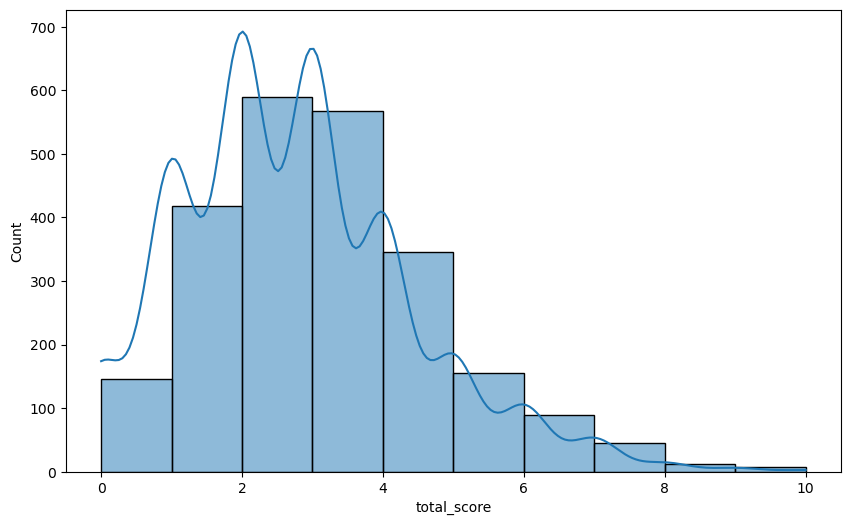

In [335]:
tpr2["total_score"] = tpr2["GF"] + tpr2["GA"]

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(tpr2["total_score"], bins=10, kde=True, edgecolor='black')

<br><br><br><br>
<h3 style="color:red;">  Regression</h3>

In [336]:
tpr2.match_result.value_counts()

match_result
2    935
1    852
0    585
Name: count, dtype: int64

In [337]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

X = tpr2[['tpr_x', 'tpr_y']]
y = tpr2['match_result']

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train the model
model = LogisticRegression(random_state=42, multi_class='multinomial', solver='lbfgs', class_weight='balanced')
model.fit(X_train, y_train)

# Step 6: Predict probabilities
y_pred_prob = model.predict_proba(X_test)
y_pred = model.predict(X_test)

# Display results
# print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

results = X_test.copy()
results['actual'] = y_test
results['predicted'] = y_pred
results['probabilities'] = list(y_pred_prob)

# for i, row in results.iterrows():
#     print(f"Sample {i}: Actual={row['actual']}, Predicted={row['predicted']}, Probabilities={row['probabilities']}")

Accuracy: 0.44842105263157894


<br><br><br><br>
<h3 style="color:red;">  Using Model with Custom Input</h3>

In [338]:
input_data = pd.DataFrame({'tpr_x': [95], 'tpr_y': [85]})  # Adjust values if necessary
predicted_class = model.predict(input_data)
predicted_probabilities = model.predict_proba(input_data)

In [339]:
results = {
    'predicted_class': predicted_class[0],
    'predicted_probabilities': {
        'win_Y': predicted_probabilities[0][1],
        'draw': predicted_probabilities[0][0],
        'win_X': predicted_probabilities[0][2]
    }
}

print(1, round(results["predicted_probabilities"]["win_X"], 2))
print(0, round(results["predicted_probabilities"]["draw"], 2))
print(2, round(results["predicted_probabilities"]["win_Y"], 2))

1 0.18
0 0.21
2 0.61


<br><br><br><br>
<h3 style="color:green;">  Saving Model Parameters to Reuse</h3>

In [340]:
coefficients = model.coef_
intercepts = model.intercept_
class_labels = model.classes_

model_params = {}

for idx, label in enumerate(class_labels):
    model_params[label] = {
        'tpr_x': coefficients[idx][0],
        'tpr_y': coefficients[idx][1],
        'intercept': intercepts[idx]
    }

In [341]:
powerX = 88
powerY = 69
powerDiff = abs(powerX-powerY)

logits = {}
for label in model_params:
    intercept = model_params[label]["intercept"]
    tpr_x_coef = model_params[label]["tpr_x"]
    tpr_y_coef = model_params[label]["tpr_y"]
    logit = intercept + tpr_x_coef * powerX + tpr_y_coef * powerY
    logits[label] = logit

logits_list = np.array(list(logits.values()))
exp_logits = np.exp(logits_list)
probabilities = exp_logits / np.sum(exp_logits)
probabilities_dict = dict(zip(logits.keys(), probabilities))

print("Logits:", logits)
print("Probabilities:", probabilities_dict)

Logits: {0: -0.0474230396421188, 1: 0.9419805223339419, 2: -0.8945574826815599}
Probabilities: {0: 0.24282033291318772, 1: 0.653096802568053, 2: 0.10408286451875923}


In [342]:
win_df = pd.DataFrame(model_params)

In [343]:
win_df

0         1         2
tpr_x     -0.008426  0.050757 -0.042332
tpr_y     -0.011465 -0.033360  0.044826
intercept  1.485149 -1.222804 -0.262345

In [344]:
win_df.loc["tpr_x", 0]
win_df.loc["tpr_y", 0]
win_df.loc["intercept", 0]

1.4851488755897884

<br><br><br><br>
<h3 style="color:green;">  Exporting CSV</h3>

In [345]:
win_df.to_csv("players_db/fm23/win_probability.csv") # EXPORT

In [346]:
pd.read_csv("players_db/fm23/win_probability.csv", index_col=0) # IMPORT

0         1         2
tpr_x     -0.008426  0.050757 -0.042332
tpr_y     -0.011465 -0.033360  0.044826
intercept  1.485149 -1.222804 -0.262345